In [1]:
from itertools import product
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy as sp
from scipy.linalg import svd
from scipy.sparse import dia_matrix, linalg, identity

from qiskit import Aer, transpile
from qiskit.circuit import QuantumCircuit
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit.opflow.primitive_ops import PauliSumOp, PauliOp
from qiskit.quantum_info import Pauli, Statevector

from banded_circulant_matrix import indices, unitary_iterate
from qsvt import single_ancilla_qsp_circuit

## Target matrix $A$

In [2]:
alpha = 1
beta = 0.25
gamma = 0.25

num_qubits = 3
dim = 2 ** num_qubits

data = np.array([
    [alpha, gamma, 0, 0, 0, 0, 0, beta],
    [beta, alpha, gamma, 0, 0, 0, 0, 0],
    [0, beta, alpha, gamma, 0, 0, 0, 0],
    [0, 0, beta, alpha, gamma, 0, 0, 0],
    [0, 0, 0, beta, alpha, gamma, 0, 0],
    [0, 0, 0, 0, beta, alpha, gamma, 0],
    [0, 0, 0, 0, 0, beta, alpha, gamma],
    [gamma, 0, 0, 0, 0, 0, beta, alpha],
])

diagonals = np.array([[gamma, beta, alpha, gamma, beta]]).repeat(dim, axis=0).transpose()
offsets = np.array([- (dim - 1), - 1, 0, 1, dim - 1])
A = dia_matrix((diagonals, offsets), shape=(dim, dim)).tolil()

A_spec = sp.linalg.eigvalsh(A.toarray())

eig_max = max(A_spec)
eig_min = min(A_spec)
kappa = abs(eig_max / eig_min)

print(
    '-' * 80,
    f'matrix size: {dim} x {dim}',
    '-' * 80,
    'target matrix A:',
    A.toarray(),
    '-' * 80,
    'eigenvalues:',
    A_spec,
    '-' * 80,
    f'condition number: {kappa}',
    '-' * 80,
    sep = '\n'
)

--------------------------------------------------------------------------------
matrix size: 8 x 8
--------------------------------------------------------------------------------
target matrix A:
[[1.   0.25 0.   0.   0.   0.   0.   0.25]
 [0.25 1.   0.25 0.   0.   0.   0.   0.  ]
 [0.   0.25 1.   0.25 0.   0.   0.   0.  ]
 [0.   0.   0.25 1.   0.25 0.   0.   0.  ]
 [0.   0.   0.   0.25 1.   0.25 0.   0.  ]
 [0.   0.   0.   0.   0.25 1.   0.25 0.  ]
 [0.   0.   0.   0.   0.   0.25 1.   0.25]
 [0.25 0.   0.   0.   0.   0.   0.25 1.  ]]
--------------------------------------------------------------------------------
eigenvalues:
[0.5        0.64644661 0.64644661 1.         1.         1.35355339
 1.35355339 1.5       ]
--------------------------------------------------------------------------------
condition number: 3.0
--------------------------------------------------------------------------------


## Matrix block encoded by $U_A$
$$B = \frac{A}{s} = \frac{A}{4}$$

In [3]:
alpha = 1 / 4
beta = 1 / 16
gamma = 1 / 16

diagonals = np.array([[gamma, beta, alpha, gamma, beta]]).repeat(dim, axis=0).transpose()
offsets = np.array([- (dim - 1), - 1, 0, 1, dim - 1])
B = dia_matrix((diagonals, offsets), shape=(dim, dim)).tolil()
B_spec = sp.linalg.eigvalsh(B.toarray())
print("Eigenvalues of matrix B:")
print(B_spec)
# print(linalg.inv(B).toarray())

Eigenvalues of matrix B:
[0.125      0.16161165 0.16161165 0.25       0.25       0.33838835
 0.33838835 0.375     ]


$$F = I - \frac{B^2}{3}$$

In [4]:
S, U = sp.linalg.eigh(B.toarray())
W = 1 - S ** 2 / 3
F = U @ np.diag(W) @ U.T
print(F)
# print(F @ B)

[[ 9.76562500e-01 -1.04166667e-02 -1.30208333e-03  1.17359169e-16
  -2.86459411e-17  1.19181333e-16 -1.30208333e-03 -1.04166667e-02]
 [-1.04166667e-02  9.76562500e-01 -1.04166667e-02 -1.30208333e-03
   1.36901249e-16  7.65617055e-17 -1.05671699e-16 -1.30208333e-03]
 [-1.30208333e-03 -1.04166667e-02  9.76562500e-01 -1.04166667e-02
  -1.30208333e-03 -4.39848048e-17 -1.98462634e-16 -2.41310773e-16]
 [ 1.26330418e-16 -1.30208333e-03 -1.04166667e-02  9.76562500e-01
  -1.04166667e-02 -1.30208333e-03  6.48068102e-17 -5.79690443e-18]
 [-2.43527195e-17  1.45794350e-16 -1.30208333e-03 -1.04166667e-02
   9.76562500e-01 -1.04166667e-02 -1.30208333e-03  2.18220229e-16]
 [ 1.08676791e-16  5.67792556e-17 -4.33714875e-17 -1.30208333e-03
  -1.04166667e-02  9.76562500e-01 -1.04166667e-02 -1.30208333e-03]
 [-1.30208333e-03 -1.05978358e-16 -2.06129101e-16  6.48068102e-17
  -1.30208333e-03 -1.04166667e-02  9.76562500e-01 -1.04166667e-02]
 [-1.04166667e-02 -1.30208333e-03 -2.54497097e-16 -2.51945485e-17
   

In [5]:
def subspace_sv(num_qubits, num_aux_qubits, sv):
    row_vec = np.zeros(2 ** num_qubits)
    keys = ["".join(k) for k in product("01", repeat=num_qubits)]
    
    for j, key in enumerate(keys):
        idx = int(key + "0" * num_aux_qubits, 2)
        row_vec[j] = np.real(sv[idx])
    
    return row_vec

## $W$: unitary iterate of $A$

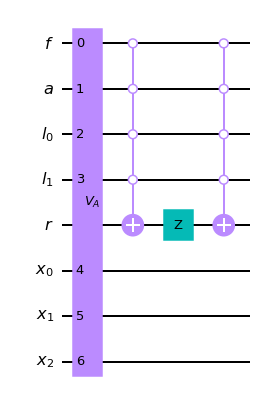

In [6]:
alpha = 1
beta = 0.25
gamma = 0.25

num_sys_qubits = 3
w = unitary_iterate(alpha, beta, gamma, num_sys_qubits, i=0, j=0, add_measurements=False)
w.draw("mpl", fold=-1)

## Quantum eigenvalue transformation

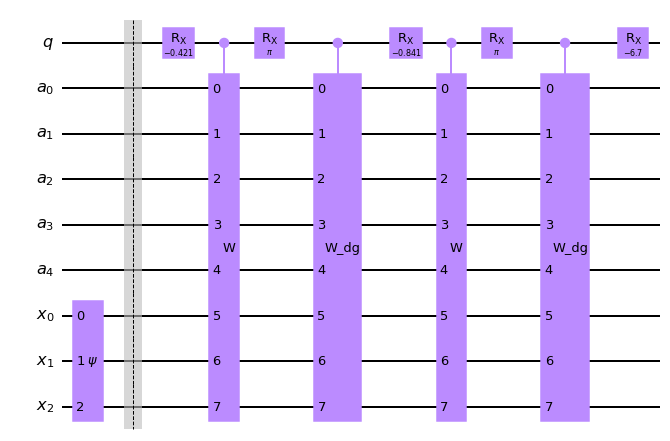

In [7]:
angles = np.array([1.781063500980373e+00, 0, -1.150262004597920e+00, 0, 2.102671741854774e-01])

ref_state = QuantumCircuit(num_qubits, name="$\psi$")
ref_state.x(0)
ref_state.x(1)

backend = Aer.get_backend("aer_simulator_statevector")
backend.set_options(precision="double")

wy = transpile(w, backend=backend)
qc = single_ancilla_qsp_circuit(ref_state, wy, angles, add_measurements=False)
qc.draw("mpl", fold=-1)

$$f(A)_{ij} = (\langle + | \otimes \langle 0^{\otimes 5} | \otimes \langle j |) U_{\Phi} (| + \rangle \otimes | 0^{\otimes 5} \rangle \otimes | i \rangle),$$
where $f(x) = 1 - \frac{x^2}{3}$.

In [8]:
num_aux_qubits = 6
amplitudes = []

for i in range(2 ** num_sys_qubits):
    # state preparation
    ref_state = QuantumCircuit(num_qubits, name="$\psi$")
    for k in indices(i):
        ref_state.x(k)
    
    qc = single_ancilla_qsp_circuit(ref_state, wy, angles, add_measurements=False)
    ai = subspace_sv(num_sys_qubits, num_aux_qubits, Statevector(qc).data)
    amplitudes.append(ai)
    print(ai)

[ 9.76562500e-01 -1.04166667e-02 -1.30208333e-03  1.03085306e-17
  3.80233558e-16  2.01954657e-17 -1.30208333e-03 -1.04166667e-02]
[-1.04166667e-02  9.76562500e-01 -1.04166667e-02 -1.30208333e-03
 -1.32137061e-16  1.45277162e-16  8.91691686e-18 -1.30208333e-03]
[-1.30208333e-03 -1.04166667e-02  9.76562500e-01 -1.04166667e-02
 -1.30208333e-03 -8.96733142e-18  3.57163020e-16  2.16331472e-16]
[-7.62445785e-17 -1.30208333e-03 -1.04166667e-02  9.76562500e-01
 -1.04166667e-02 -1.30208333e-03  1.90325434e-16  3.80728053e-16]
[ 1.09160838e-15 -1.14813132e-16 -1.30208333e-03 -1.04166667e-02
  9.76562500e-01 -1.04166667e-02 -1.30208333e-03 -7.11652913e-17]
[-1.31449177e-16  9.97392645e-16 -3.06348027e-17 -1.30208333e-03
 -1.04166667e-02  9.76562500e-01 -1.04166667e-02 -1.30208333e-03]
[-1.30208333e-03  1.48755463e-17  7.55911382e-16 -2.13465204e-17
 -1.30208333e-03 -1.04166667e-02  9.76562500e-01 -1.04166667e-02]
[-1.04166667e-02 -1.30208333e-03  3.72038587e-17  6.77697869e-17
 -7.67440070e-17 -

### Errors analysis
- $v_i = \Vert F_{ij} - f(A) | i \rangle \Vert_1$
- Spectral norm (L1-norm): $\Vert v_i \Vert_1 / \sqrt{N} < \epsilon$ 

In [9]:
l1_norms = []
for vec1, vec2 in zip(F, amplitudes):
    l1_norms.append(LA.norm(vec1 - vec2, ord=1) / np.sqrt(8))

print(l1_norms)

[7.214896804207144e-15, 7.290814875884471e-15, 7.318973959501234e-15, 7.834255113964304e-15, 8.386184069355046e-15, 8.566122148710403e-15, 7.99231347843799e-15, 8.42516793812899e-15]
